In [2]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from glob import glob
import seaborn as sns

In [3]:
data = pd.read_csv('./fem/data/legend.csv')

In [4]:
title = list(data['image'])

In [5]:
data.columns

Index(['user.id', 'image', '1', 'emotion'], dtype='object')

In [6]:
fem = "fem/images"

In [7]:
images = []
classes =[]
for image_path in glob(os.path.join(fem,"*.jpg")):
    image_bgr = cv2.imread(image_path)
    resized_img = cv2.resize(image_bgr,(28,28))
    if image_bgr is None:
        continue
    
    ind = title.index(image_path[11:])
    class_label = data['emotion'][ind]
    images.append(resized_img)
    classes.append(class_label)

In [8]:
np.unique(classes)

array(['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral',
       'sadness', 'surprise'], dtype='<U9')

In [9]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y = enc.fit_transform(classes)

In [10]:
y.shape,len(images)

((13680, 8), 13680)

In [11]:
images = np.array(images)
classes = np.array(classes)
for label in set(classes):
  print("number of {} images is  -> {}".format(label,len(images[classes == label])))

number of contempt images is  -> 9
number of neutral images is  -> 6863
number of anger images is  -> 252
number of fear images is  -> 21
number of sadness images is  -> 267
number of surprise images is  -> 368
number of disgust images is  -> 208
number of happiness images is  -> 5692


In [12]:
images.shape

(13680, 28, 28, 3)

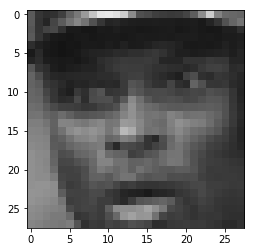

In [13]:
plt.imshow(images[11000])

In [14]:
from sklearn.model_selection import train_test_split

In [54]:
x_train,x_test,y_train,y_test = train_test_split(images,y,test_size =.05)

In [36]:
x_test,x_val,y_test,y_val = train_test_split(x_test,y_test,test_size=.5)

In [55]:
x_test.shape,x_train.shape,y_test.shape,y_train.shape

((684, 28, 28, 3), (12996, 28, 28, 3), (684, 8), (12996, 8))

In [56]:
x_test = x_test.reshape(684,28,28,3)
x_train = x_train.reshape(12996,28,28,3)

In [57]:
from tensorflow.keras.layers import Dense,Dropout,Conv2D,Flatten,BatchNormalization
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.preprocessing import image

In [58]:
tf.reset_default_graph()

In [59]:
model = Sequential()

In [60]:
model.add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(28,28,3)))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(8, activation='softmax'))

In [61]:
model.compile('adam','categorical_crossentropy',metrics=['accuracy'])

In [62]:
model.fit(x_train,
           y_train,
           epochs=50,
           batch_size =256,
           callbacks =None,
           validation_data=(x_test,y_test)
           )

Train on 12996 samples, validate on 684 samples
Epoch 1/50
12996/12996 [==============================] - 79s 6ms/sample - loss: 1.9123 - acc: 0.4890 - val_loss: 1.2551 - val_acc: 0.6506
Epoch 2/50
12996/12996 [==============================] - 78s 6ms/sample - loss: 0.9761 - acc: 0.7711 - val_loss: 0.8993 - val_acc: 0.7544
Epoch 3/50
12996/12996 [==============================] - 76s 6ms/sample - loss: 0.7676 - acc: 0.8002 - val_loss: 0.7559 - val_acc: 0.7822
Epoch 4/50
12996/12996 [==============================] - 76s 6ms/sample - loss: 0.7086 - acc: 0.8051 - val_loss: 0.6658 - val_acc: 0.7939
Epoch 5/50
12996/12996 [==============================] - 79s 6ms/sample - loss: 0.6359 - acc: 0.8145 - val_loss: 0.6415 - val_acc: 0.7997
Epoch 6/50
  768/12996 [>.............................] - ETA: 1:18 - loss: 0.6257 - acc: 0.8112

KeyboardInterrupt: 

In [63]:
pred = model.predict(x_test.reshape(-1,28,28,3))

In [64]:
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical

In [65]:
pred_ix = [list(row).index(np.max(row))for row in pred]

In [66]:
pred_new = np.array(pred_ix)
pred_new = to_categorical(pred_new)
pred_new.shape

(684, 8)

In [67]:
accuracy_score(pred_new,y_test)

0.8099415204678363

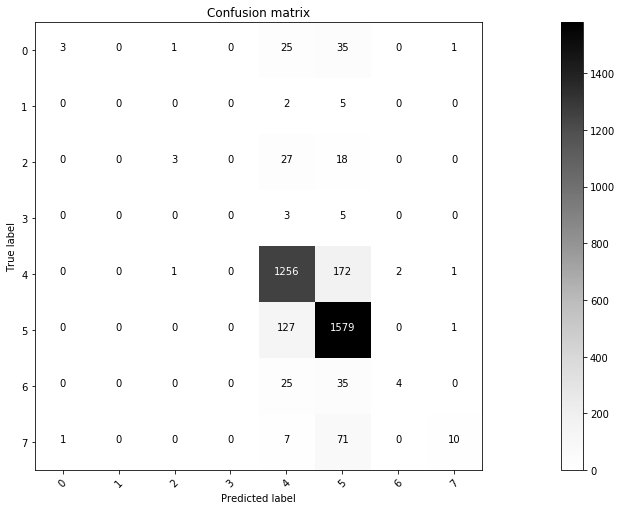

In [68]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7))  
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greys):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
y_pred = model.predict(x_val) 
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = np.argmax(y_val,axis = 1) 
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(8))

## Testing of Model

In [69]:
im = cv2.imread("happy.jpg")

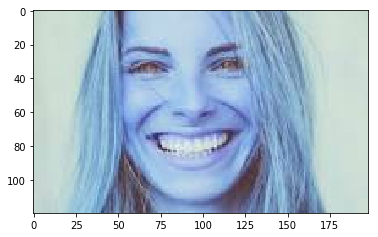

In [70]:
plt.imshow(im)

In [71]:
im = cv2.resize(im,(28,28))

In [72]:
pre = model.predict(im.reshape(-1,28,28,3))

In [73]:
pre_ix = [list(row).index(np.max(row))for row in pre]

In [74]:
(np.unique(classes))[pre_ix]

array(['happiness'], dtype='<U9')

In [77]:
im3 = cv2.imread("2.jpg")

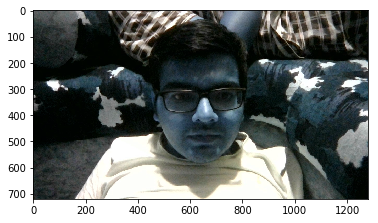

In [78]:
plt.imshow(im3)

In [79]:
im3 = cv2.resize(im3,(28,28))

In [80]:
pre = model.predict(im3.reshape(-1,28,28,3))

In [81]:
pre_ix = [list(row).index(np.max(row))for row in pre]

In [82]:
(np.unique(classes))[pre_ix]

array(['happiness'], dtype='<U9')